In [1]:
import os
import sys

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

In [167]:
from collections import defaultdict
from flow_wmd.documents import Document
from flow_wmd.gale_shapeley import Matcher
from flow_wmd.models import LC_RWMD, WMD, WMDManyToMany, WMDPairs
from flow_wmd.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [3]:
PATH = "../data/"
imdb_data = pd.read_csv(f"{PATH}IMDB_Dataset.csv")
stopword_list=stopwords.words('english')

### 1.2 Remove special formatting and stopwords

Remove stopwords before denoising, lemmatizing and removing special characters.

In [7]:
%%time 

tokenizer=ToktokTokenizer()
imdb_data['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in imdb_data['review']]

CPU times: user 35.4 s, sys: 223 ms, total: 35.7 s
Wall time: 36.1 s


Denoise, remove special characters, lemmatize.

In [11]:
%%time

imdb_data['review_clean']=imdb_data['review_clean'].apply(denoise_text)
imdb_data['review_clean']=imdb_data['review_clean'].apply(remove_special_characters)
imdb_data['review_clean']=imdb_data['review_clean'].apply(simple_lemmatizer)

CPU times: user 24.8 s, sys: 192 ms, total: 25 s
Wall time: 25.3 s


Remove stopwords again, after other preprocessing.

In [17]:
%%time 

imdb_data['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in imdb_data['review_clean']]

CPU times: user 19.8 s, sys: 67.1 ms, total: 19.8 s
Wall time: 20 s


Data _before_ preprocessing.

In [18]:
imdb_data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Data _after_ preprocessing.

In [19]:
imdb_data['review_clean'][0]

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz m

### 1.3 Separate pos and neg reviews

In [20]:
pos = imdb_data[imdb_data.sentiment == "positive"].reset_index(drop=True)
neg = imdb_data[imdb_data.sentiment == "negative"].reset_index(drop=True)

In [21]:
pos = pos.review_clean.tolist()
neg = neg.review_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [29]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos[:500]))
neg_tok = list(map(lambda x: tokenize(x, tokenizer), neg[:500]))

In [30]:
pos_sample = [" ".join(doc) for doc in pos_tok]
neg_sample = [" ".join(doc) for doc in neg_tok]

### 2.2 Load pretrained Google News W2V model

In [32]:
finetuned = True

In [34]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using IMDB review data.")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/imdb_w2v.txt', binary=False)

Loading GoogleNews Vectors finetuned using IMDB review data.
CPU times: user 18.9 s, sys: 273 ms, total: 19.2 s
Wall time: 19.4 s


### 2.3 Load corpus and remove OOV words

In [39]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 21 µs
CPU times: user 241 ms, sys: 5.27 ms, total: 246 ms
Wall time: 247 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7ff61fd320d0>,
                use_idf=False)

In [40]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 12.1 ms, sys: 439 µs, total: 12.5 ms
Wall time: 12.4 ms


In [41]:
len(oov)

2037

In [45]:
%time pos_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), pos_sample[:500]))
%time neg_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), neg_sample[:500]))

CPU times: user 1.5 s, sys: 6.75 ms, total: 1.51 s
Wall time: 1.52 s
CPU times: user 1.4 s, sys: 5.97 ms, total: 1.4 s
Wall time: 1.41 s


In [46]:
pos_sample[0]

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz m

In [48]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 26 µs
CPU times: user 227 ms, sys: 3.78 ms, total: 231 ms
Wall time: 230 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7ff61fd320d0>)

Bag-of-words vectorizer.

In [49]:
%time
pos_nbow = vectorizer.transform(pos_sample)
neg_nbow = vectorizer.transform(neg_sample)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


In [51]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos_sample[:500]))
neg_tok =list(map(lambda x: tokenize(x, tokenizer), neg_sample[:500]))

In [52]:
pos_tok[0][:20]

['one',
 'reviewer',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scene',
 'violence',
 'set',
 'right']

In [53]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 14.6 ms, sys: 539 µs, total: 15.2 ms
Wall time: 14.9 ms


In [54]:
len(oov_)

0

### 2.4 Get features and embeddings

In [55]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [56]:
E = np.vstack([model.get_vector(word) for word in vectorizer.get_feature_names()])

### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with Kmeans and assigning each word to a cluster.

First, we get the embeddings for the words that are in our feature space.

In [57]:
X = model[features]

Then we select the number of clusters we want, initialize the Kmeans model and fit it.

In [60]:
%%time

sum_of_squared_distances = []
K = range(5,105, 5)
for k in K:
    print(k)
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
CPU times: user 17min 23s, sys: 2min 15s, total: 19min 39s
Wall time: 3min 54s


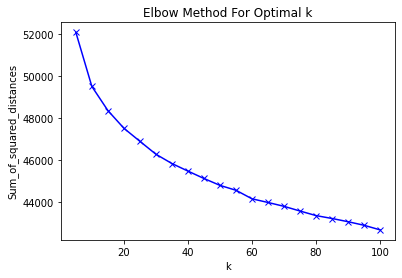

In [63]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [64]:
NUM_CLUSTERS = 100
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS, verbose=0)
kmeans.fit(X)

KMeans(n_clusters=100)

Assign labels and centroids to separate variables for later use.

In [65]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Create an index that maps each word to a cluster.

In [66]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

In [68]:
print(take(10, word2cluster.items()))

[('aaargh', 12), ('aaliyah', 45), ('aamir', 28), ('aaron', 79), ('ab', 28), ('abandon', 0), ('abandoned', 77), ('abba', 12), ('abbey', 97), ('abbot', 97)]


Now, conversely, create an index that maps each cluster to a word.

In [69]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

In [70]:
print(cluster2words[0][:100])

['abandon', 'accepting', 'activity', 'adamant', 'addict', 'admits', 'adoption', 'aggression', 'agreeing', 'aiming', 'alcoholism', 'alert', 'alleged', 'allegiance', 'angered', 'answering', 'application', 'asserts', 'assures', 'authority', 'avoiding', 'basterds', 'behalf', 'betray', 'betraying', 'blaming', 'blindly', 'blocked', 'bravely', 'brink', 'casualty', 'caused', 'cease', 'censor', 'charged', 'cheat', 'chooses', 'choosing', 'circumstance', 'citizen', 'complacent', 'compliance', 'complicate', 'condition', 'confront', 'confronted', 'conscious', 'considers', 'console', 'consume', 'consumed', 'control', 'controlling', 'convenience', 'converted', 'cope', 'counter', 'crisis', 'daily', 'damage', 'damaged', 'damnation', 'dealing', 'dealt', 'deciding', 'declare', 'dedicated', 'defect', 'defend', 'defense', 'denied', 'denying', 'dependency', 'deprived', 'desired', 'desperately', 'destitute', 'deterred', 'discredit', 'disease', 'dormant', 'drastic', 'drug', 'duty', 'earning', 'enable', 'enabl

### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [71]:
pos_nbow[0]

<1x14766 sparse matrix of type '<class 'numpy.float64'>'
	with 133 stored elements in Compressed Sparse Row format>

In [72]:
%%time 

pos_docs, neg_docs = [], []

for idx, doc in enumerate(pos_tok):
    pos_docs.append(Document(doc, pos_nbow[idx], word2idx, E))
    
for idx, doc in enumerate(neg_tok):
    neg_docs.append(Document(doc, neg_nbow[idx], word2idx, E))

CPU times: user 221 ms, sys: 63.6 ms, total: 285 ms
Wall time: 285 ms


In [73]:
pos_docs[0].nbow

array([[0., 0., 0., ..., 0., 0., 0.]])

In [74]:
pos_docs[0].weights_sum

1.0

In [75]:
pos_docs[0].idxs[:10]

[9728, 13334, 9238, 10277, 6187, 4652, 6699, 10286, 2094, 6701]

In [76]:
pos_docs[0].vecs[:1][0][:10]

array([-0.03184877,  0.08938561, -0.23239496, -0.22144787,  0.00298812,
       -0.16498049, -0.1524208 ,  0.21617717, -0.37542573,  0.06170934],
      dtype=float32)

### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [77]:
%time lc_rwmd = LC_RWMD(pos_docs, neg_docs,pos_nbow,neg_nbow,E)
%time lc_rwmd.get_D()
#%time lc_rwmd.get_L(1)
#%time lc_rwmd.get_rwmd()

CPU times: user 13 µs, sys: 12 µs, total: 25 µs
Wall time: 28.8 µs
CPU times: user 2min 22s, sys: 21 s, total: 2min 43s
Wall time: 42.8 s


### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [127]:
%%time

matcher = Matcher(lc_rwmd.D)
engaged = matcher.matchmaker()
matcher.check()
pairs = engaged

CPU times: user 1.05 s, sys: 19.3 ms, total: 1.07 s
Wall time: 1.08 s


Let's look at the output of Gale-Shapeley:

In [128]:
take(10, pairs.items())

[(185, 299),
 (35, 473),
 (336, 28),
 (188, 248),
 (101, 148),
 (253, 15),
 (133, 258),
 (104, 259),
 (131, 377),
 (107, 10)]

In [129]:
example_pairs = [(' '.join(word for word in pos_docs[p[0]].words), 
                  ' '.join(word for word in neg_docs[p[1]].words))
                 for p in take(10, pairs.items())]

In [134]:
example_pairs[9][0]

'game rank far honor playing mine p graphic really good voice acting standard difficulty level right best character series opinion story amazed took many different twist expecting rating game deserves great'

In [135]:
example_pairs[9][1]

'terrible misfortune view entirety say save time money got worst time even called like fails aspect make good movie story interesting actor believable bad direction action sequence fake almost funny almost movie packed full crappy oneliners respectable person could find amusing least little bit movie supposed geared towards men woman utterly unattractive especially old wrinkled thing come towards end try appear sexy weird horrible costume fail miserably even ridiculous still give laugh painful watch'

### 2.9 Pairwise WMD

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [174]:
%%time 

wmd_pairs = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs.get_distances(thread=False)

Calculated distances between 0 documents.
Calculated distances between 100 documents.
Calculated distances between 200 documents.
Calculated distances between 300 documents.
Calculated distances between 400 documents.
CPU times: user 2min 26s, sys: 13.4 s, total: 2min 39s
Wall time: 1min 9s


The return value is a matrix of distances between the document pairs.

In [175]:
wmd_pairs.distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [176]:
%%time 

wmd_pairs_flow = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow.get_distances(return_flow = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 12s, sys: 13.2 s, total: 2min 25s
Wall time: 1min 14s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [177]:
wmd_pairs_flow.distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [178]:
take(10, wmd_pairs_flow.wc_X1.items())

[('youtube', 0.09996),
 ('interest', 0.6890999999999999),
 ('bumping', 0.02748),
 ('amateur', 0.07795),
 ('abbreviated', 0.0189),
 ('frisky', 0.02511),
 ('renovated', 0.03214),
 ('cue', 0.00858),
 ('drive', 0.31423),
 ('keaton', 0.1514)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [179]:
take(10, wmd_pairs_flow.wc_X2.items())

[('youtube', 0.00701),
 ('interest', 1.0196800000000001),
 ('superstar', 0.029),
 ('amateur', 0.17423),
 ('critique', 0.19007000000000002),
 ('tremaine', 0.022299999999999997),
 ('skiing', 0.03281),
 ('shabby', 0.03551),
 ('effeminate', 0.04624),
 ('abbreviated', 0.01819)]

In [180]:
take(10, wmd_pairs_flow.cc_X1.items())

[(12, 8.81814),
 (45, 7.456930000000001),
 (28, 12.431749999999997),
 (79, 20.24658999999999),
 (0, 13.81794999999999),
 (77, 11.385559999999998),
 (97, 7.7232999999999965),
 (9, 19.64446),
 (10, 13.37141),
 (27, 10.543320000000005)]

In [181]:
take(10, wmd_pairs_flow.cc_X2.items())

[(12, 11.17188),
 (45, 3.565390000000001),
 (28, 10.005869999999993),
 (79, 13.041610000000007),
 (0, 12.748129999999998),
 (77, 8.873689999999996),
 (97, 6.21828),
 (9, 11.726469999999994),
 (10, 14.408119999999993),
 (27, 7.2023300000000035)]

In [182]:
{k: v for k, v in sorted(wmd_pairs_flow.cc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{24: 94.88465000000011,
 1: 54.117840000000044,
 21: 49.316789999999976,
 4: 47.05581999999993,
 73: 39.62008999999993,
 65: 38.74738999999996,
 55: 37.468270000000025,
 19: 34.56766999999994,
 69: 33.85297,
 39: 33.70846}

In [185]:
wmd_pairs_flow.get_differences()

### 3.1 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [186]:
{k: v for k, v in sorted(wmd_pairs_flow.wc_X1_diff.items(), key=lambda item: item[1], reverse=True)[:30]}

{'great': 3.684119999999999,
 'love': 3.0659199999999993,
 'best': 2.9734699999999994,
 'young': 2.7412799999999993,
 'still': 2.678639999999999,
 'performance': 2.4275899999999995,
 'excellent': 2.3056899999999994,
 'game': 2.0037299999999996,
 'loved': 1.9072999999999998,
 'favorite': 1.8927700000000005,
 'wonderful': 1.8905500000000002,
 'well': 1.87352,
 'little': 1.7632000000000012,
 'dvd': 1.6582800000000009,
 'life': 1.63394,
 'family': 1.6094199999999994,
 'song': 1.47339,
 'perfect': 1.42944,
 'story': 1.3294199999999994,
 'role': 1.3280399999999997,
 'brilliant': 1.3100100000000001,
 'italian': 1.24688,
 'new': 1.2368199999999991,
 'man': 1.1952799999999986,
 'beautiful': 1.1913199999999997,
 'always': 1.1710000000000003,
 'enjoy': 1.1691700000000005,
 'father': 1.1628599999999998,
 'romantic': 1.1478600000000003,
 'amazing': 1.1355700000000002}

Next, let's see what added most distance when moving from the negative to the positive reviews.

In [187]:
{k: v for k, v in sorted(wmd_pairs_flow.wc_X2_diff.items(), key=lambda item: item[1], reverse=True)[:30]}

{'bad': 7.070259999999994,
 'worst': 4.54303,
 'waste': 3.59436,
 'money': 2.8272600000000008,
 'even': 2.721729999999998,
 'stupid': 2.58822,
 'awful': 2.4731899999999998,
 'ever': 2.3345599999999997,
 'boring': 2.2304399999999993,
 'movie': 2.1923999999999992,
 'terrible': 2.1853499999999992,
 'plot': 2.10646,
 'poor': 2.1032800000000003,
 'guy': 1.963889999999999,
 'instead': 1.9381299999999997,
 'acting': 1.905740000000001,
 'rating': 1.85195,
 'nothing': 1.8448299999999993,
 'rent': 1.7515500000000002,
 'could': 1.7412000000000019,
 'made': 1.6352300000000013,
 'least': 1.5719700000000003,
 'horrible': 1.5380399999999996,
 'supposed': 1.4540500000000003,
 'say': 1.442960000000001,
 'worse': 1.4196200000000003,
 'better': 1.4166099999999995,
 'hour': 1.348899999999999,
 'minute': 1.3478999999999997,
 'dull': 1.29528}

Finally, let's look at the distances between the two sets by clustering similar words, in order to get a better sense of what kind of "topics" that separate them. Each cluster has a weight that matches the sum of the words belonging to that cluster. We choose *n* top clusters to inspect. To make the clusters interpretable, we also represent each of them by *m* keywords, selected based on the cost they individually add between the two sets.

In [188]:
n_clusters = 50
n_words = 10

c1 = output_clusters(wc=wmd_pairs_flow.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow.cc_X1.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2 = output_clusters(wc=wmd_pairs_flow.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow.cc_X2.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

Positive to negative clusters.

In [189]:
c1

,24,1,21,4,73,65,55,19,69,39,...,37,80,50,6,35,85,0,11,10,34
0,hope (0.8),edge (0.96),still (2.68),little (1.76),robin (0.78),performance (2.43),later (0.71),real (0.73),masterpiece (1.07),great (3.68),...,attention (0.69),best (2.97),man (1.2),lovely (0.79),novel (0.42),message (0.89),justice (0.4),history (0.86),muresan (0.23),team (0.6)
1,time (0.59),take (0.89),enjoy (1.17),nice (0.66),joe (0.69),role (1.33),last (0.66),major (0.63),genius (0.93),excellent (2.31),...,without (0.33),favorite (1.89),father (1.16),sexy (0.54),hamlet (0.41),lesson (0.56),seek (0.34),western (0.37),gheorghe (0.17),battle (0.47)
2,wish (0.58),keep (0.84),definitely (1.03),although (0.64),john (0.65),play (0.72),remember (0.46),different (0.57),true (0.75),wonderful (1.89),...,level (0.31),greatest (0.84),lover (0.3),lady (0.36),adaptation (0.37),documentary (0.43),solution (0.32),community (0.27),bonham (0.13),fighting (0.26)
3,doubt (0.51),side (0.56),feel (0.84),part (0.58),brown (0.6),supporting (0.64),took (0.44),question (0.52),work (0.73),perfect (1.43),...,confidence (0.23),favourite (0.77),caring (0.26),seductive (0.31),literature (0.28),issue (0.36),dealing (0.25),folk (0.26),liebmann (0.11),member (0.24)
4,whether (0.36),behind (0.39),fan (0.82),plus (0.55),jim (0.57),playing (0.52),forgotten (0.41),important (0.42),cinema (0.71),brilliant (1.31),...,immense (0.22),finest (0.5),realizes (0.2),elvira (0.26),faithful (0.24),gay (0.31),authority (0.22),depicting (0.25),taft (0.11),leader (0.24)
5,matter (0.35),move (0.39),enjoyed (0.66),typical (0.5),jones (0.55),talented (0.47),june (0.34),minor (0.34),art (0.61),beautiful (1.19),...,physical (0.17),stupidest (0.25),troubled (0.17),shy (0.24),accurate (0.24),society (0.31),dealt (0.22),bend (0.25),beckham (0.1),rescue (0.23)
6,automatically (0.29),break (0.38),worth (0.63),course (0.43),lee (0.52),caine (0.46),hit (0.33),notice (0.31),picture (0.6),amazing (1.14),...,skill (0.17),absolute (0.21),engaged (0.16),handsome (0.23),biography (0.21),stance (0.25),learning (0.17),honor (0.24),welker (0.09),illegal (0.22)
7,anywhere (0.28),run (0.35),may (0.42),plenty (0.33),mickey (0.5),flynn (0.36),ran (0.24),missing (0.23),gem (0.57),incredible (1.06),...,satisfaction (0.16),arguably (0.21),coward (0.16),distress (0.18),page (0.19),cultural (0.25),fearing (0.16),taught (0.22),obv (0.09),men (0.18)
8,another (0.22),come (0.25),experience (0.36),though (0.28),kevin (0.48),portrayal (0.36),started (0.23),included (0.22),era (0.38),superb (0.94),...,difficulty (0.15),coolest (0.13),learns (0.16),gorgeous (0.17),poem (0.17),social (0.22),support (0.16),common (0.2),orhan (0.08),union (0.17)
9,one (0.21),hold (0.24),taste (0.29),filled (0.25),robert (0.47),believable (0.34),july (0.22),note (0.22),hitchcock (0.35),fantastic (0.81),...,accuracy (0.11),undoubtedly (0.05),whose (0.15),heroine (0.15),vonnegut (0.16),subject (0.2),duty (0.15),opposed (0.19),antic (0.08),training (0.17)


Negative to positive clusters.

In [190]:
c2 

,24,4,1,88,21,15,55,19,75,14,...,44,6,89,86,93,13,79,0,7,52
0,even (2.72),instead (1.94),go (0.74),got (1.28),enough (1.08),bad (7.07),made (1.64),case (1.24),seemed (1.23),plot (2.11),...,sex (1.0),woman (0.48),morning (0.29),earth (0.68),angst (0.38),suddenly (0.39),jason (0.42),receiving (0.4),bunch (0.78),guy (1.96)
1,movie (2.19),nothing (1.84),getting (0.61),really (1.27),expect (0.9),stupid (2.59),went (1.03),fact (0.67),bored (1.17),action (1.16),...,violence (0.7),girl (0.44),surf (0.19),destroy (0.31),mental (0.21),cure (0.29),sue (0.32),saving (0.21),looking (0.5),ugly (0.38)
2,could (1.74),pretty (0.99),stay (0.58),ok (1.09),watching (0.8),awful (2.47),seen (0.68),problem (0.67),hated (0.68),lack (1.07),...,nudity (0.64),female (0.33),dinner (0.19),machine (0.25),existence (0.17),mad (0.28),charlie (0.31),task (0.19),drink (0.36),santa (0.32)
3,say (1.44),whole (0.98),next (0.54),maybe (1.07),disappointed (0.76),terrible (2.19),ended (0.59),apparently (0.49),left (0.59),viewer (0.63),...,porn (0.52),lesbian (0.32),theatre (0.17),size (0.25),imaginary (0.17),becomes (0.26),joey (0.23),severe (0.15),drinking (0.26),wannabe (0.31)
4,better (1.42),rest (0.74),get (0.49),thing (1.04),bore (0.64),poor (2.1),gone (0.56),point (0.46),confused (0.53),whatsoever (0.52),...,disgusting (0.51),hot (0.3),club (0.12),serum (0.25),surrounding (0.14),happens (0.2),andy (0.21),surround (0.14),candy (0.2),spoiled (0.3)
5,anything (1.16),premise (0.73),start (0.47),mean (0.95),otherwise (0.58),horrible (1.54),finished (0.55),clue (0.46),disappointment (0.49),explanation (0.44),...,gratuitous (0.34),topless (0.27),rave (0.12),computer (0.23),precisely (0.13),whale (0.19),matt (0.15),trusted (0.14),beating (0.19),idiot (0.26)
6,something (0.99),basically (0.7),back (0.42),going (0.84),skip (0.48),worse (1.42),fox (0.54),particular (0.34),looked (0.48),development (0.43),...,extreme (0.32),babe (0.21),premiere (0.09),facility (0.23),traumatic (0.11),insane (0.18),kathryn (0.15),cheat (0.13),smoking (0.17),stereotypical (0.21)
7,else (0.97),unfortunately (0.69),open (0.41),oh (0.79),faint (0.32),cheap (1.03),came (0.54),main (0.31),expected (0.45),lacked (0.41),...,crude (0.3),psychic (0.2),school (0.09),enterprise (0.22),foundation (0.1),becoming (0.16),nephew (0.14),resource (0.12),toilet (0.17),goofy (0.21)
8,idea (0.96),complete (0.66),finish (0.32),suck (0.75),insomnia (0.2),lame (0.9),first (0.44),explained (0.26),brought (0.32),zero (0.39),...,nasty (0.28),chick (0.2),ceremony (0.03),mass (0.21),observes (0.1),appears (0.16),adam (0.13),protocol (0.12),wet (0.17),freak (0.2)
9,unless (0.92),redeeming (0.61),sign (0.3),spoiler (0.7),see (0.15),badly (0.83),episode (0.39),reference (0.25),ruined (0.32),motivation (0.38),...,rape (0.28),plump (0.18),birthday (0.03),large (0.18),study (0.09),supposedly (0.16),uncle (0.11),drug (0.12),vomiting (0.17),nut (0.19)


## Appendix: Many-to-many WMD

This was a first attempt to do the flows from words between many documents, without first filtering using Gale-Shapeley. However, this proved too inefficient. As you can see looking at the CPU times, it is very slow even with extremely small samples and the time complexity is quadratic (or worse?), meaning it rapidly gets even worse as the sample size increases.

In [155]:
%time m2m_distances = WMDManyToMany(pos_docs[:20], neg_docs[:20],E,idx2word).get_distances(return_flow = False)

CPU times: user 1min 48s, sys: 12.7 s, total: 2min 1s
Wall time: 50 s


In [156]:
%time m2m_distances_flow, wc_X1, wc_X2 = WMDManyToMany(pos_docs[:20],neg_docs[:20],E,idx2word).get_distances(return_flow = True)

CPU times: user 1min 52s, sys: 13.5 s, total: 2min 5s
Wall time: 51.4 s


In [157]:
{k: v for k, v in sorted(wc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{'karen': 8.69223,
 'wrenching': 8.31882,
 'carpenter': 7.468960000000001,
 'laughter': 7.467879999999999,
 'liked': 6.864090000000003,
 'mom': 6.791519999999999,
 'gut': 6.759419999999999,
 'love': 6.551409999999997,
 'camp': 6.533080000000001,
 'hr': 6.1393699999999995}

In [158]:
{k: v for k, v in sorted(wc_X2.items(), key=lambda item: item[1], reverse=True)[:10]}

{'hopper': 8.372459999999998,
 'jake': 7.63837,
 'movie': 7.267059999999995,
 'film': 6.936379999999998,
 'shakespeare': 5.99276,
 'oddness': 5.53033,
 'terrible': 4.943440000000001,
 'parent': 4.751790000000001,
 'actor': 4.672620000000001,
 'bad': 4.430020000000002}